# Step 0. Read in Data and NLTK Basics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
# Read in data
df = pd.read_csv('sample_data/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

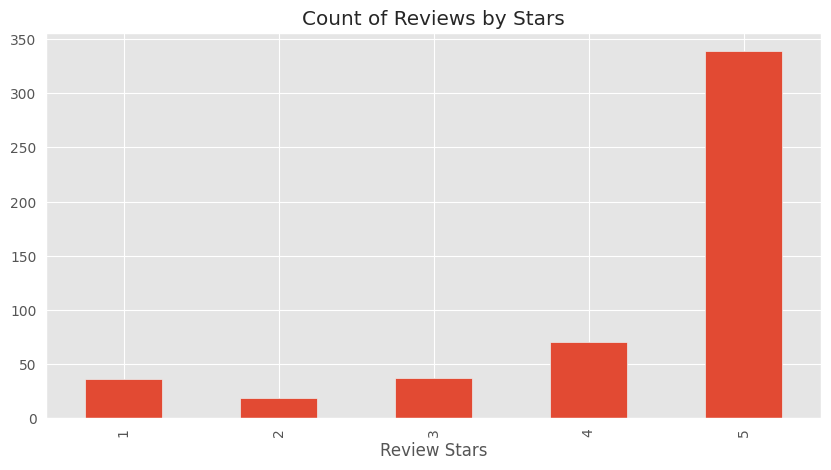

In [ ]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [ ]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

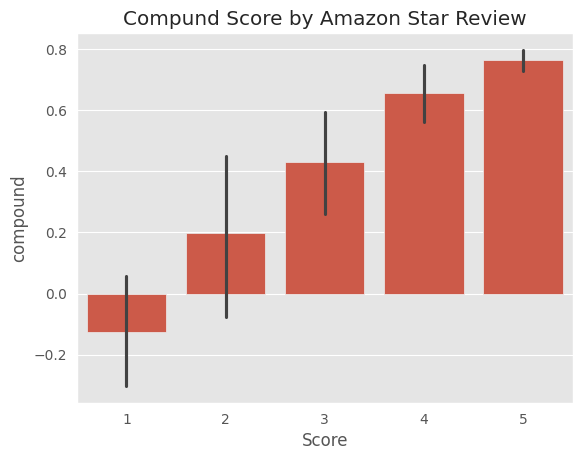

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

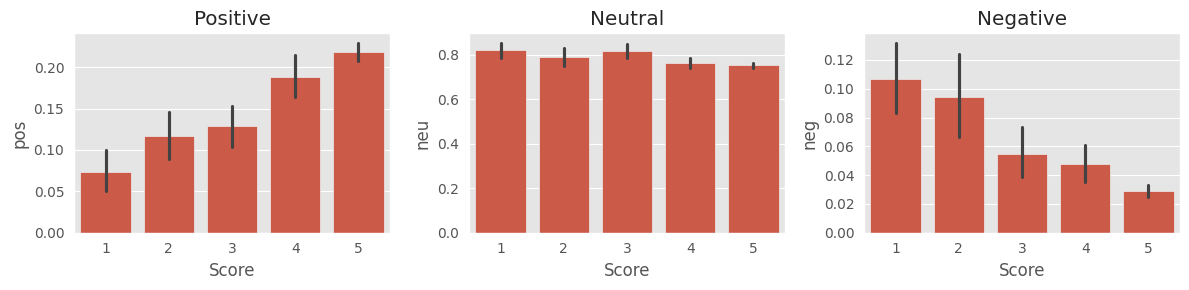

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_text)
    scores = softmax(output.logits[0].numpy())
    compound = scores[2] - scores[0]  # positive score - negative score
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2],
        'roberta_compound': compound
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError as e:
        print(f'Broke for id {myid} with error {e}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83 with error The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]
Broke for id 187 with error The expanded size of the tensor (546) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 546].  Tensor sizes: [1, 514]


In [ ]:
results_df = pd.DataFrame.from_dict(res, orient='index').reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [ ]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'roberta_compound',
       'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

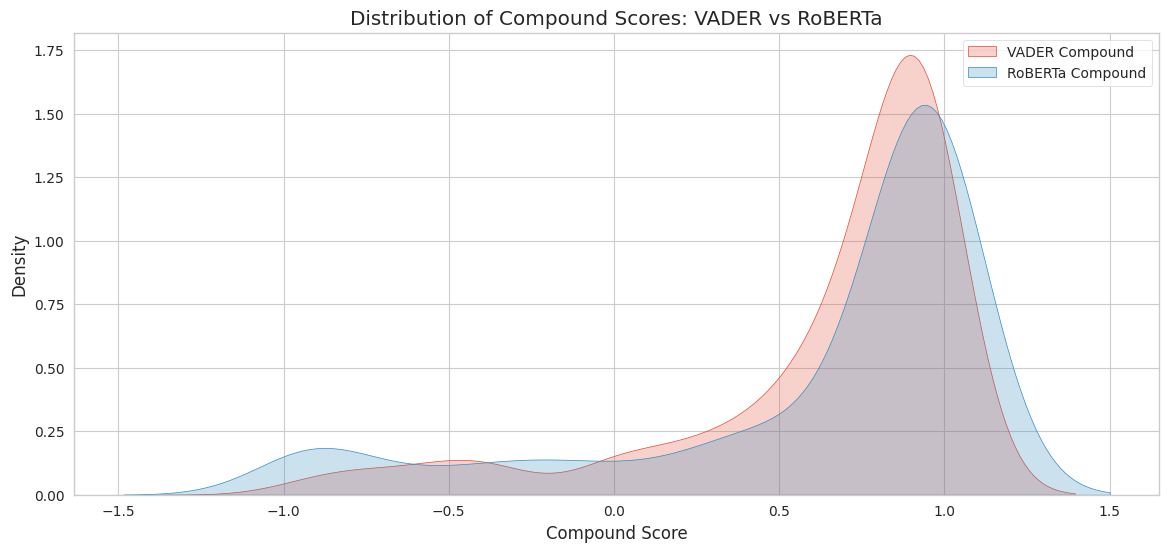

In [ ]:
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting the distribution of compound scores
plt.figure(figsize=(14, 6))

# VADER compound score distribution
sns.kdeplot(results_df['vader_compound'], label='VADER Compound', fill=True)

# RoBERTa compound score distribution
sns.kdeplot(results_df['roberta_compound'], label='RoBERTa Compound', fill=True)

plt.title('Distribution of Compound Scores: VADER vs RoBERTa')
plt.xlabel('Compound Score')
plt.ylabel('Density')
plt.legend()
plt.show()


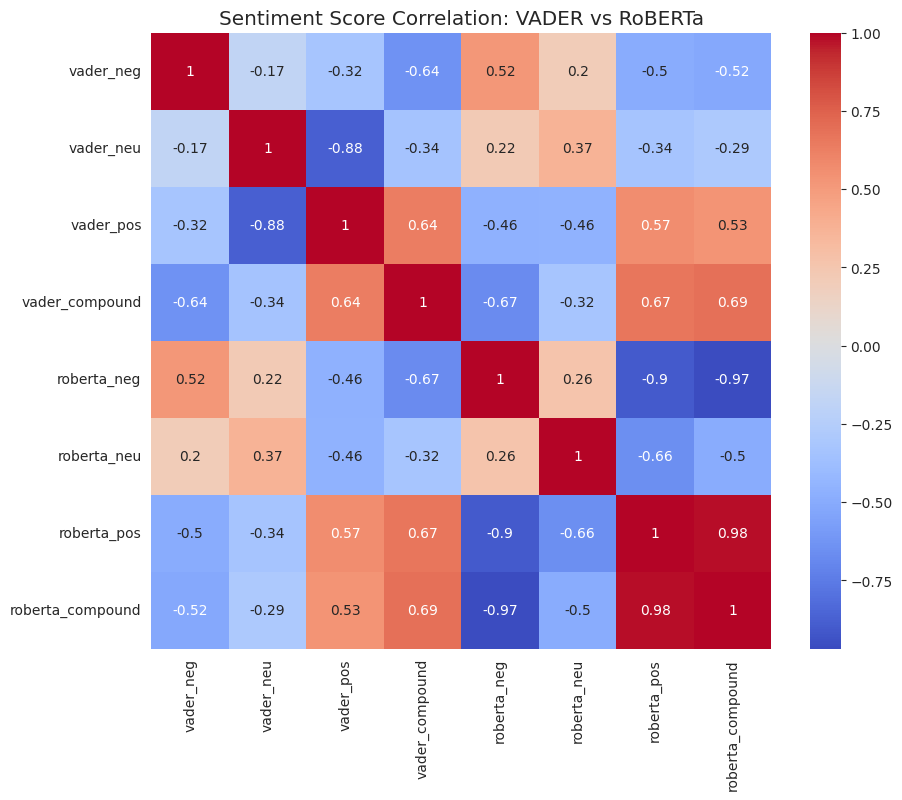

In [ ]:
 # Focus on sentiment scores for correlation
sentiment_scores = results_df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                               'roberta_neg', 'roberta_neu', 'roberta_pos', 'roberta_compound']]

# Calculating the correlation matrix
correlation_matrix = sentiment_scores.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Sentiment Score Correlation: VADER vs RoBERTa')
plt.show()


Logistic Regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
df.columns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 2: Preparing the **Data**

In [ ]:
# Assuming 'Score' ranges from 1 to 5; simplifying to binary classification for example
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)


# Step 3: Tokenize Text and Prepare for **Doc2Vec**

In [ ]:
# Tokenizing text data and tagging each text with unique IDs
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['Text'])]


# **Step 4: Train Doc2Vec Model**

In [ ]:
# Defining and training a Doc2Vec model
model_d2v = Doc2Vec(vector_size=100, alpha=0.025, min_alpha=0.00025, min_count=1, dm=1)

model_d2v.build_vocab(tagged_data)

# Training the Doc2Vec model
for epoch in range(10):
    model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)
    # Decrease the learning rate
    model_d2v.alpha -= 0.0002
    # Fix the learning rate, no decay
    model_d2v.min_alpha = model_d2v.alpha

model_d2v.save("d2v.model")
print("Model Saved")


Model Saved


# Step 5: Prepare Feature Vectors for Logistic **Regression**

In [ ]:
# Generating feature vectors for each document
vectors = [model_d2v.infer_vector(doc.words) for doc in tagged_data]

X = np.array(vectors)
y = df['Sentiment'].values


# **Step 6: Split the Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Step 7: Train Logistic Regression Model**

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# **Step 8: Model Evaluation**

In [ ]:
predictions = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.29      0.11      0.15        19
           1       0.82      0.94      0.87        81

    accuracy                           0.78       100
   macro avg       0.55      0.52      0.51       100
weighted avg       0.72      0.78      0.74       100



In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')  # Make sure the 'punkt' tokenizer is downloaded

# Function to preprocess and predict sentiment of a new text
def predict_sentiment(text):
    # Tokenize and convert text to lowercase
    tokenized_text = word_tokenize(text.lower())

    # Infer the vector for the new text using the trained Doc2Vec model
    vector = model_d2v.infer_vector(tokenized_text)

    # Predict the sentiment using the trained Logistic Regression model
    prediction = lr.predict([vector])

    # Return the sentiment prediction (0 for Negative, 1 for Positive)
    return "Positive" if prediction[0] == 1 else "Negative"

# Example text
text = "I hate this cake."
result = predict_sentiment(text)
print("The predicted sentiment is:", result)


The predicted sentiment is: Positive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize  # Make sure to import word_tokenize

nltk.download('punkt')  # This downloads the necessary tokenizers

# Assuming 'Score' ranges from 1 to 5; simplifying to binary classification
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Prepare the text data
texts = df['Text'].apply(lambda x: x.lower())

# Vectorizing text data using TF-IDF
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words='english', min_df=2)
X = tfidf.fit_transform(texts).toarray()
y = df['Sentiment'].values

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining and training the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Making predictions
predictions = rf.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.81      1.00      0.90        81

    accuracy                           0.81       100
   macro avg       0.41      0.50      0.45       100
weighted avg       0.66      0.81      0.72       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import openai

# Replace 'your-api-key' with your actual OpenAI API key
openai.api_key = 'sk-proj-Q1XxFGn5CtYyVkF1egPVT3BlbkFJ9JHj9HwrFvI4z9rK3Y48'


ModuleNotFoundError: No module named 'openai'

In [ ]:
def analyze_sentiment_gpt3(text):
    response = openai.Completion.create(
      engine="text-davinci-002",  # As of my last training cut-off, check for the latest model version
      prompt=f"Analyze the sentiment of this text: \"{text}\". Is it positive, negative, or neutral? Give me values from 0 to 1 to the particular field",
      max_tokens=60
    )
    # The response will contain the text with the sentiment analysis
    return response.choices[0].text.strip()

In [ ]:
# Example function to apply sentiment scoring to a DataFrame
def append_gpt_sentiment(df):
    df[['gpt_neg', 'gpt_neu', 'gpt_pos']] = df['Text'].apply(
        lambda text: pd.Series(gpt_sentiment_scores(text))
    )
    return df

# Applying the function to your DataFrame
results_df = append_gpt_sentiment(results_df)


NameError: name 'gpt_sentiment_scores' is not defined

In [ ]:
results_df


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,roberta_compound,ProductId,...,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,gpt_neg,gpt_neu,gpt_pos
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,0.930771,B001E4KFG0,...,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.0,0.0,0.0
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,-0.470386,B00813GRG4,...,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0,0.0,0.0
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,0.895475,B000LQOCH0,...,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...,0.0,0.0,0.0
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,0.905190,B000UA0QIQ,...,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...,0.0,0.0,0.0
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,0.986428,B006K2ZZ7K,...,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,996,0.026,0.721,0.253,0.9788,0.001335,0.006112,0.992553,0.991217,B006F2NYI2,...,Swopes,1.0,1.0,5.0,1.331856e+09,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,0.0,0.0,0.0
990,997,0.000,0.786,0.214,0.9309,0.002649,0.016077,0.981274,0.978625,B006F2NYI2,...,Mike A.,1.0,1.0,5.0,1.328141e+09,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...",0.0,0.0,0.0
991,998,0.000,0.673,0.327,0.9634,0.001362,0.011372,0.987266,0.985903,B006F2NYI2,...,kefka82,1.0,1.0,5.0,1.324253e+09,this sauce is the shiznit,this sauce is so good with just about anything...,0.0,0.0,0.0
992,999,0.063,0.874,0.062,-0.0129,0.661606,0.293687,0.044707,-0.616899,B006F2NYI2,...,V. B. Brookshaw,1.0,2.0,1.0,1.336090e+09,Not Hot,Not hot at all. Like the other low star review...,0.0,0.0,0.0


# Step 3. Combine and compare

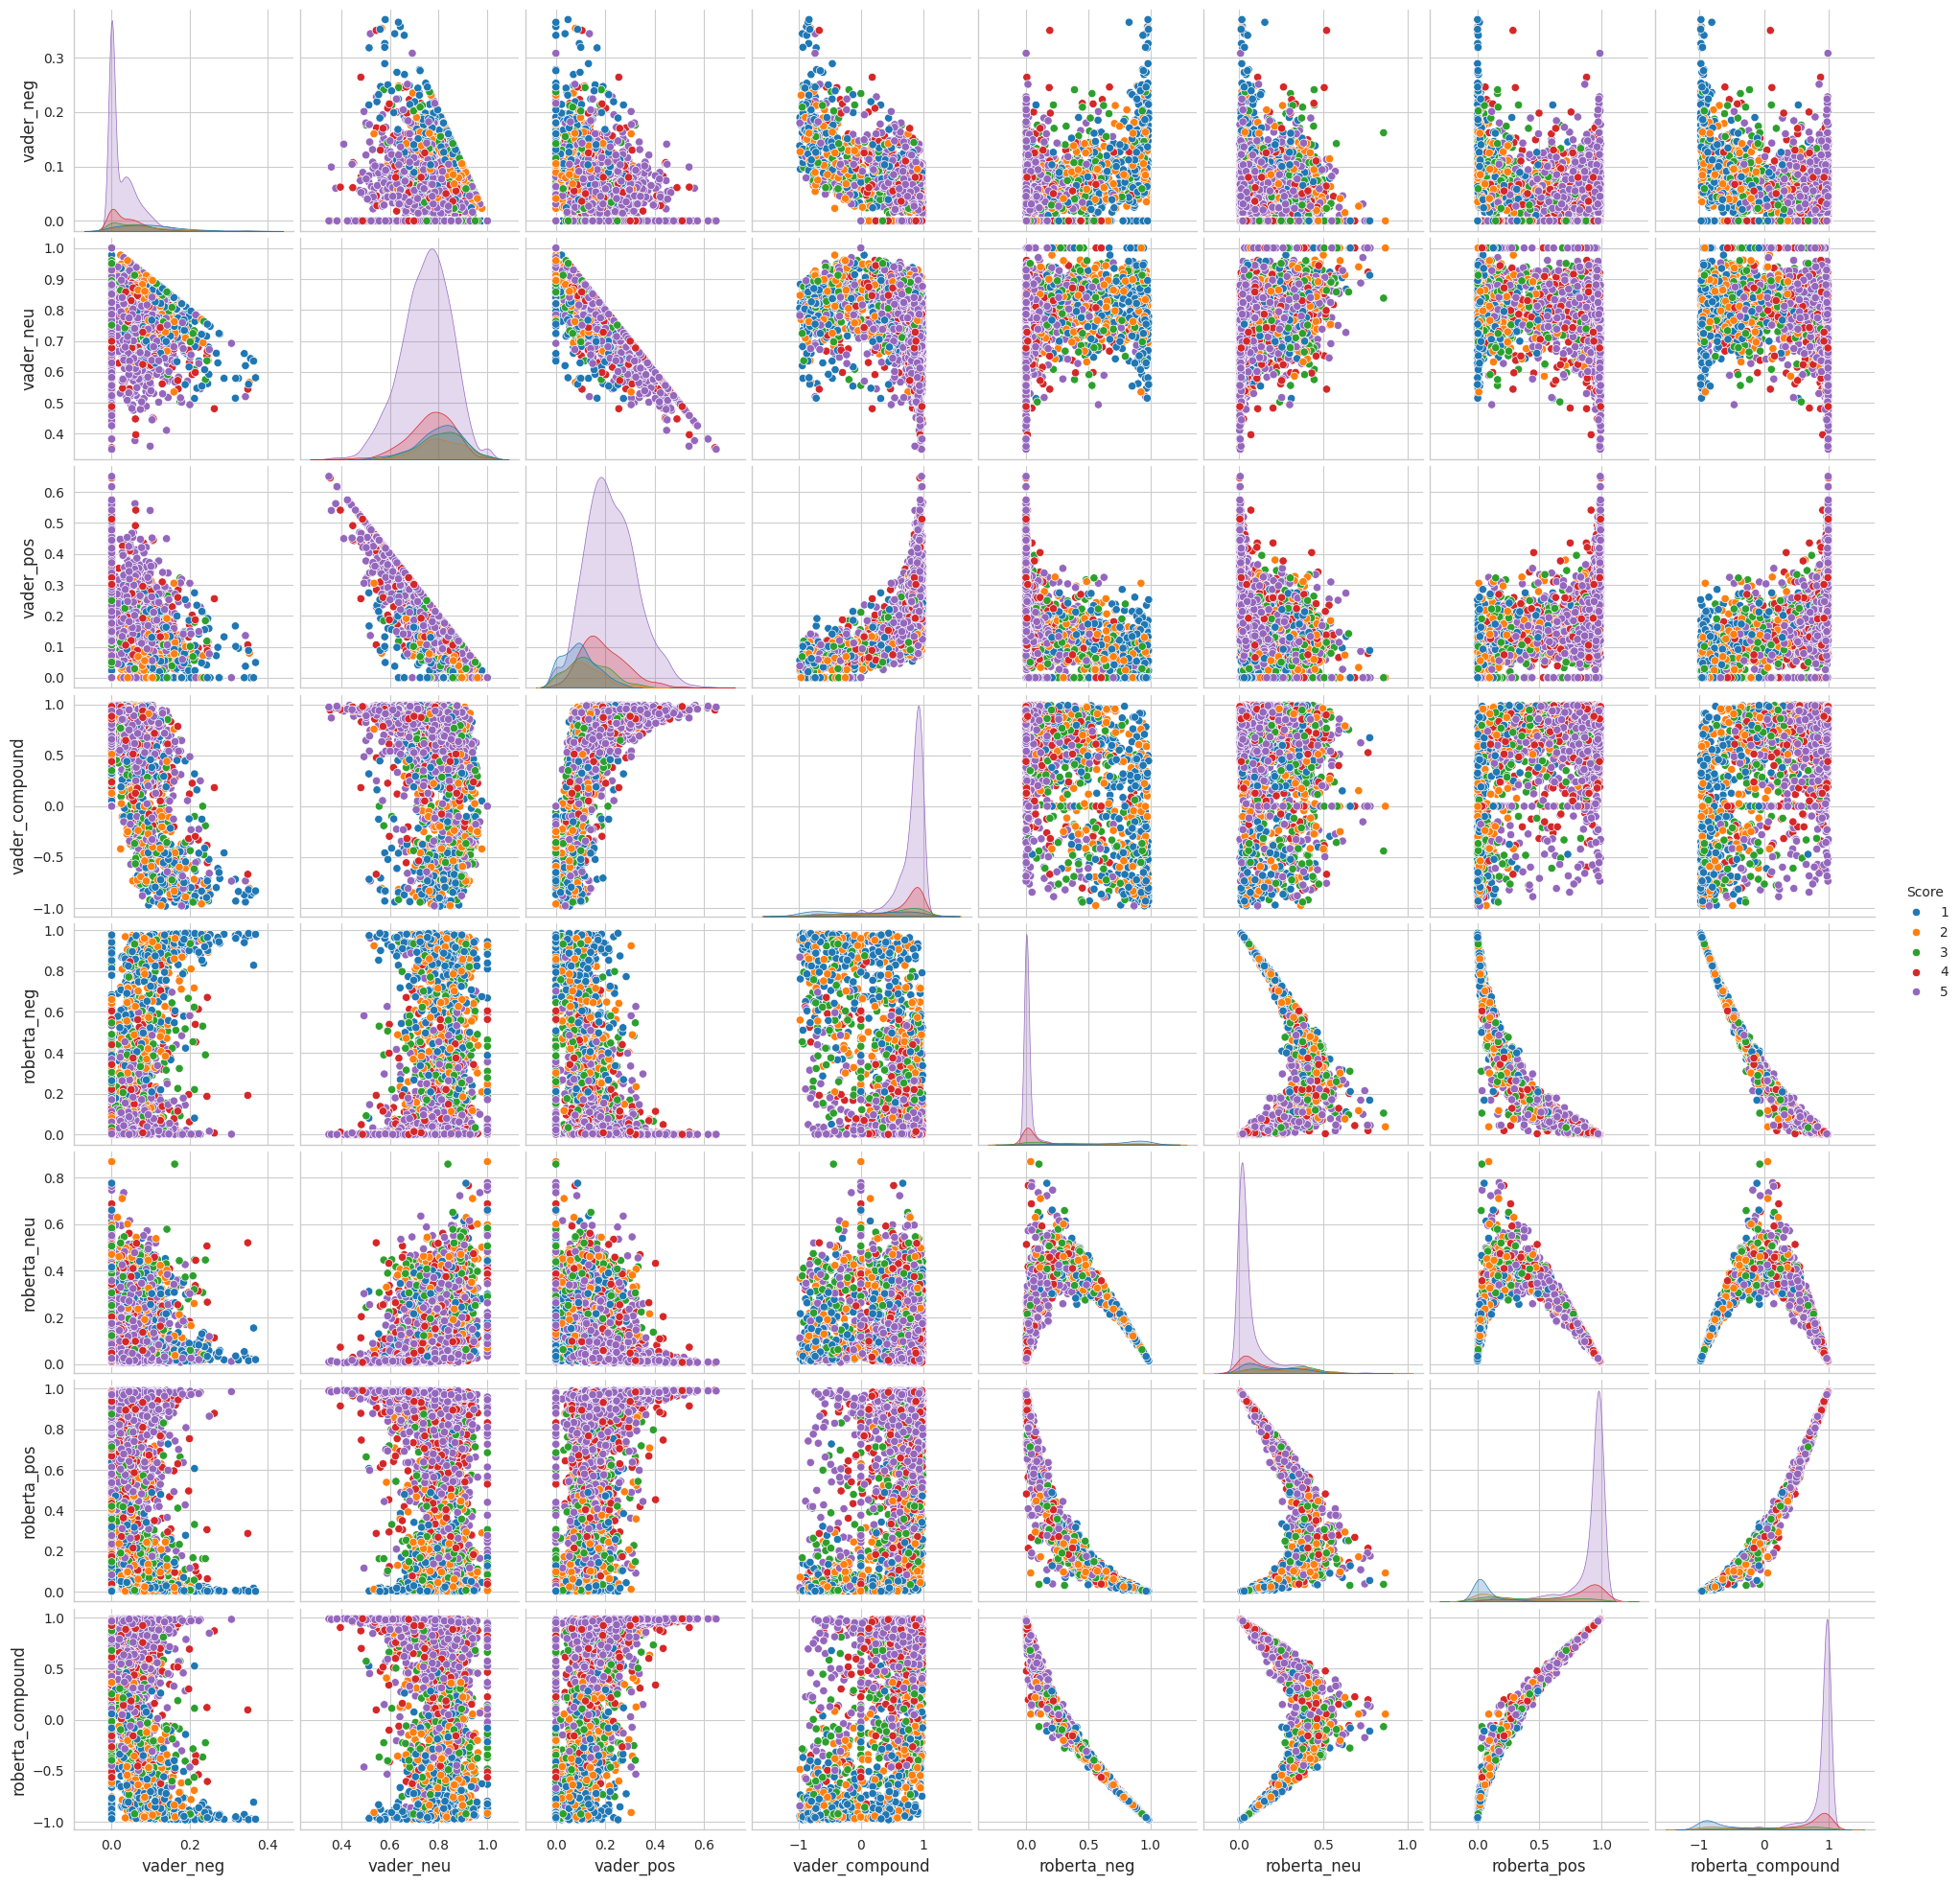

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                  'roberta_neg', 'roberta_neu', 'roberta_pos', 'roberta_compound'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The End